# Getting the Environment Setup

In [0]:
# Import necessary Dependencies
import numpy as np
import xml.etree.ElementTree as ET
from google.colab import drive
import pickle
import xml
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

# User Parameters

In [0]:
label_data_loc = "/content/drive/My Drive/CSCI_5391/labels.pkl"
n_channels = 384

# List of all the recordings you would like to include
partial_names_of_interest = ['08-10-38_1', '10-25-04_5'] 
# partial_names_of_interest = ['08-10-38_1', '09-11-15_3', '09-44-15_4', '10-25-04_5'] 


# Get Access to Data Files from Google Drive

In [0]:
# Load the data from google drive
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/CSCI_5391/'  #change dir to your project folder

# List contents of the folder holding out data (make sure the data is there)
!ls "/content/drive/My Drive/CSCI_5391"
!ls "/content/drive/My Drive/CSCI_5391/M310016_2017-06-15_08-10-38_1"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 data_compilations		 M310016_2017-06-15_10-25-04_5
 experiment1_103-1_0.dat	 M310016_2017-06-15_10-52-16_6
 getting_channel_numbers.ipynb	 M310016_2017-06-15_11-21-18_7
 labels.pkl			 M310016_2017-06-15_11-51-37_8
 M310016_2017-06-14_09-37-02	 pics_for_dan
 M310016_2017-06-15_08-10-38_1	 settings.xml
 M310016_2017-06-15_09-11-15_3	'Untitled document.gdoc'
 M310016_2017-06-15_09-44-15_4	'Untitled presentation.gslides'
experiment1_103-0_0.dat
experiment1_103-1_0.dat
experiment1_all_channels_0.events
experiment1_messages_0.events
first_10m_test_input_3s_lfp_above_in.npy
first_10m_test_input_3s_lfp.npy
first_10m_test_input_3s.npy
first_10m_test_labels_3s_lfp_above_in.npy
first_10m_test_labels_3s_lfp.npy
first_10m_test_labels_3s.npy
first_10m_train_input_3s_lfp_above_in.npy
first_10m_train_input_3s_lfp.npy
first_10m_train_input_3s.npy
first_10m_train_labels_3s_lfp

In [0]:
!ls "/content/drive/My Drive/CSCI_5391"

 data_compilations		 M310016_2017-06-15_10-25-04_5
 experiment1_103-1_0.dat	 M310016_2017-06-15_10-52-16_6
 getting_channel_numbers.ipynb	 M310016_2017-06-15_11-21-18_7
 labels.pkl			 M310016_2017-06-15_11-51-37_8
 M310016_2017-06-14_09-37-02	 pics_for_dan
 M310016_2017-06-15_08-10-38_1	 settings.xml
 M310016_2017-06-15_09-11-15_3	'Untitled document.gdoc'
 M310016_2017-06-15_09-44-15_4	'Untitled presentation.gslides'


# Get the region labels for every recording site

Here we generate a dictionary that holds the labels of all the sites recorded from in each session. The key to each dictionary entry is the unique partial file name in each recording (the time of the recording)

In [0]:
#Generate a list of all regions recorded from
print("Generating list of regions")
regions_list = []
label_data = pickle.load(open(label_data_loc,"rb"))
for recording in label_data:
  if not isinstance(recording, str):
    for area in label_data[recording]:
      if area.lower() not in regions_list:
        regions_list.append(area.lower())
regions_list = sorted(regions_list)
num_regions = len(regions_list)

# Categorize every site in current recording.
empty_label_set = np.zeros((n_channels, num_regions), dtype=bool)
all_site_categories = np.copy(empty_label_set)
all_site_labels = {}
for recording in label_data:
  if not isinstance(recording, str):
    string_output = recording.decode("utf-8")
    print(string_output)
    for partial_name in partial_names_of_interest:
      if partial_name in string_output:
        all_site_labels[partial_name] = np.copy(empty_label_set)
        for area in label_data[recording]:
          sites_in_area = []
          this_recording_area = label_data[recording][area]
          range_start = this_recording_area[0]
          range_end = this_recording_area[1] + 1
          region_index = regions_list.index(area.lower())
          for channel in range(range_start, range_end):
            sites_in_area.append(channel)
            all_site_categories[channel][region_index] = True
            all_site_labels[partial_name][channel][region_index] = True

Generating list of regions
/Volumes/SD1/DanD/M310016/localization/M310016_2017-06-15_10-52-16_6
/Volumes/SD1/DanD/M310016/localization/M310016_2017-06-15_09-11-15_3
/Volumes/SD1/DanD/M310016/localization/M310016_2017-06-15_08-43-17_2
/Volumes/SD1/DanD/M310016/localization/M310016_2017-06-15_09-55-55_4b
/Volumes/SD1/DanD/M310016/localization/M310016_2017-06-15_11-21-18_7
/Volumes/SD1/DanD/M310016/localization/M310016_2017-06-15_11-51-37_8
/Volumes/SD1/DanD/M310016/localization/M310016_2017-06-15_09-44-15_4
/Volumes/SD1/DanD/M310016/localization/M310016_2017-06-15_10-25-04_5
/Volumes/SD1/DanD/M310016/localization/M310016_2017-06-15_08-10-38_1


# Some Verification Tests

Wasn't sure if I was loading the right thing. Here are some checks that I did.

In [0]:
for session_id, recording_labels in all_site_labels.items():
  total_labeled_sites = np.sum(recording_labels)
  print("Session " + session_id + " had \t" + str(total_labeled_sites) + " total labels")

Session 10-25-04_5 had 	384 total labels
Session 08-10-38_1 had 	384 total labels


# Visualize Distribution of Recording Sites Throughout the Brain

We do not have an equal amount of representaiton from each recording site throughout the brain. Here we plot out their distribution so that we can now how much data we have for each region.

**Possibly flag the regions that are picked up in more than one recording. These provide a more robust idea of the training data**

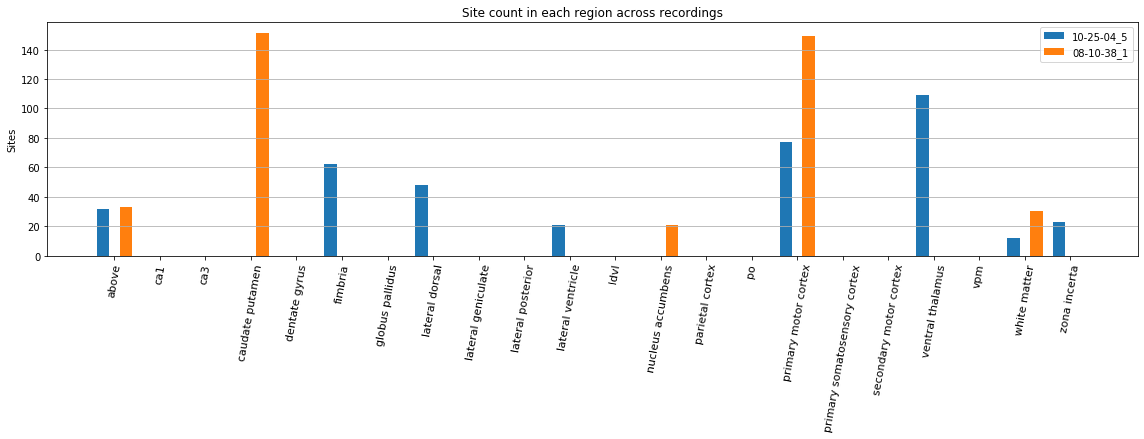

In [0]:
x = np.arange(len(regions_list)) - 0.5 # the label locations
width = 0.55/len(partial_names_of_interest)  # the width of the bars

bar_locs = np.linspace(-0.25, 0.25, len(partial_names_of_interest))

# Set up figure 
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(4)

rects = [None] * len(partial_names_of_interest)
index = 0
for session_id, recording_labels in all_site_labels.items():
  total_labeled_sites = np.sum(recording_labels, axis=0)
  rects[index] = ax.bar(x + bar_locs[index], total_labeled_sites, width, label=session_id)
  index += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sites')
ax.set_title('Site count in each region across recordings')
ax.set_xticks(x)
ax.set_xticklabels(regions_list)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=80)
ax.tick_params(axis='x', labelsize=11)
plt.grid(True, axis='y')
plt.show()

# Grab the sites of interest and accompanying labels

These will be stored in a dictionary

In [0]:
sites_of_interest_all = {}
labels_of_interest = {}

regions_of_interest = [0, 15] # for above vs in
# regions_of_interest = [0, 3, 5, 7, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21]
min_sites_in_region = 20
max_sites_in_region = 20

for session_id, recording_labels in all_site_labels.items():
  sites_of_interest_all[session_id] = []
  brain_regions_counts = np.sum(recording_labels, axis=0)
  for region_of_interest in regions_of_interest:
    count_in_reg = brain_regions_counts[region_of_interest]
    if count_in_reg >= min_sites_in_region:
      current_reg = regions_list[region_of_interest]
      print("Found " + str(count_in_reg) + " " + current_reg + " sites in session " + session_id)
      sites_in_region = np.argwhere(recording_labels[:,region_of_interest] == True)
      if sites_in_region.shape[0] > max_sites_in_region:
        sites_in_region_subset = np.random.choice(sites_in_region[:,0], size=max_sites_in_region, replace=False)
      else:
        sites_in_region_subset = np.copy(sites_in_region)
      for site in sites_in_region_subset:
        sites_of_interest_all[session_id].append(int(site))
    
  # Generate label
  labels_of_interest[session_id] = recording_labels[sites_of_interest_all[session_id]]

Found 32 above sites in session 10-25-04_5
Found 77 primary motor cortex sites in session 10-25-04_5
Found 33 above sites in session 08-10-38_1
Found 149 primary motor cortex sites in session 08-10-38_1


# Define Function that will be used for getting data

In [0]:
def get_chunk(mm,start,end,channels,sampling_rate=30000):
  chunk = mm[int(start*sampling_rate*int(channels)):int(np.floor(end*sampling_rate*(int(channels))))]
  a = np.reshape(chunk,(int(channels),-1),order='F')  * 0.195
  return a

def normalize_chunk(chunk):
  """Normalize each channel of neuropix data to have a min of 0 and max of 1"""
  
  # Get number of channels
  n_channels = chunk.shape[0]

  # Bring minimum to zero
  each_row_min = np.zeros((n_channels, 1))
  each_row_min[:,0] = chunk.min(axis=1)
  chunk_zero_min = np.copy(chunk)
  chunk_zero_min = chunk_zero_min - each_row_min

  # Bring maximum to one
  each_row_max = np.zeros((n_channels, 1))
  each_row_max[:,0] = chunk_zero_min.max(axis=1)
  chunk_one_max = np.copy(chunk_zero_min)
  # chunk_one_max = chunk_one_max / each_row_max

  return chunk_one_max

def etree_to_dict(t):
    d = {t.tag : list(map(etree_to_dict, t.getchildren()))}
    d.update(('@' + k, v) for k, v in t.attrib.items())
    d['text'] = t.text
    return d

def get_channel_count(path,from_channel_map = True,from_templates=False):
    d = etree_to_dict(ET.parse(os.path.join(path,'settings.xml')).getroot())
    chs =0
    if from_templates:
        return np.load(open(os.path.join(path,'templates.npy'))).shape[-1]
    if d['SETTINGS'][1]['SIGNALCHAIN'][0]['@name'] == 'Sources/Neuropix':
        for info in d['SETTINGS'][1]['SIGNALCHAIN'][0]['PROCESSOR'][:385]:
            if 'CHANNEL' in info.keys():
                if info['CHANNEL'][0]['@record'] == '1':
                    chs +=1
        return chs
    if d['SETTINGS'][1]['SIGNALCHAIN'][0]['@name'] == 'Sources/Rhythm FPGA':
        if from_channel_map:
            for nm in d['SETTINGS'][1]['SIGNALCHAIN']:
                name = nm['@name']
                if name == 'Filters/Channel Map':
                    #chs = np.shape(d['SETTINGS'][1]['SIGNALCHAIN'][0]['PROCESSOR'][0]['CHANNEL_INFO'])[0]
                    for info in nm['PROCESSOR']:
                        if 'CHANNEL' in info.keys():
                            if info['CHANNEL'][0]['@record'] == '1':
                                chs +=1
        else:
            for info in d['SETTINGS'][1]['SIGNALCHAIN'][0]['PROCESSOR'][:385]:
                if 'CHANNEL' in info.keys():
                    if info['CHANNEL'][0]['@record'] == '1':
                        chs +=1
        return chs



# Load Neuropixel Data
And prepare accompanying labels

# Fetch LFP data from multiple recordings

In [0]:
#Create memory maps
data_paths = {}
for unique_string in partial_names_of_interest:
  data_paths[unique_string] = '/content/drive/My Drive/CSCI_5391/M310016_2017-06-15_' + unique_string + '/experiment1_103-1_0.dat'
print(data_paths)    

memory_maps = {}
row_of_interest = {}
number_of_rows = 0
for session_id, recording_labels in all_site_labels.items():
  print("Session: " + session_id)
  print(np.sum(labels_of_interest[session_id]))
  row_of_interest[session_id] = np.sum(labels_of_interest[session_id])
  number_of_rows += np.sum(labels_of_interest[session_id])
  memory_maps[session_id] = np.memmap(data_paths[session_id], dtype=np.int16, mode='r')
  print(sites_of_interest_all[session_id])

counter_starts = {}
counter_sum = 0
for session_id in partial_names_of_interest:
  counter_starts[session_id] = counter_sum
  counter_sum += row_of_interest[session_id]
  print(session_id)
  print(counter_starts[session_id])

{'08-10-38_1': '/content/drive/My Drive/CSCI_5391/M310016_2017-06-15_08-10-38_1/experiment1_103-1_0.dat', '10-25-04_5': '/content/drive/My Drive/CSCI_5391/M310016_2017-06-15_10-25-04_5/experiment1_103-1_0.dat'}
Session: 10-25-04_5
40
[367, 383, 381, 382, 354, 376, 368, 355, 361, 369, 352, 360, 365, 374, 372, 364, 359, 378, 356, 358, 280, 327, 313, 301, 318, 345, 284, 329, 331, 302, 299, 319, 316, 303, 346, 283, 348, 321, 338, 290]
Session: 08-10-38_1
40
[372, 378, 377, 358, 381, 361, 366, 370, 363, 364, 352, 374, 383, 354, 368, 359, 360, 351, 365, 355, 238, 217, 237, 274, 310, 210, 290, 272, 240, 243, 277, 332, 246, 230, 235, 215, 209, 311, 247, 275]
08-10-38_1
0
10-25-04_5
40


In [0]:
# User Parameters
n_channels = 384
n_channels_of_interest = number_of_rows
seconds = 3
sampling_rate = 2500
n_sections = 100

# Pre-allocate space in memory for dataset
print("Preallocating arrays")
n_rows = n_sections*n_channels_of_interest
n_cols = seconds*sampling_rate
input_dataset_lfp = np.empty((n_rows, n_cols), dtype=np.float16)
label_dataset_lfp = np.empty((n_rows, len(regions_list)), dtype=np.float16)
print(input_dataset_lfp.shape)
print(label_dataset_lfp.shape)

for recording in partial_names_of_interest:
  # # Load data into preallocated arrays
  print("Loading " + str(recording))
  counter = counter_starts[recording]
  time_start = 0
  current_data_chunk = np.zeros((n_channels,n_cols), dtype=np.float16)
  data_chunk_of_interest = np.zeros((row_of_interest[recording],n_cols), dtype=np.float16)

  for section in range(n_sections):
    time_start += seconds
    time_end = time_start + seconds
    endpoint = counter + row_of_interest[recording]
    current_data_chunk[:,:] = get_chunk(memory_maps[recording], time_start, time_end, n_channels, sampling_rate)
    data_chunk_of_interest[:,:] = current_data_chunk[sites_of_interest_all[recording],:]
    normalized_chunk = normalize_chunk(data_chunk_of_interest)
    normalized_chunk_f16 = normalized_chunk.astype(dtype=np.float16)
    input_dataset_lfp[counter:endpoint, 0:n_cols] = normalized_chunk_f16
    label_dataset_lfp[counter:endpoint, 0:len(regions_list)] = all_site_labels[recording][sites_of_interest_all[recording]][:]
    counter += n_channels_of_interest
    print("Loaded section " + str(section))
print(str(counter) + " datapoints loaded")
print(input_dataset_lfp.size)

Preallocating arrays
(8000, 7500)
(8000, 22)
Loading 08-10-38_1
Loaded section 0
Loaded section 1
Loaded section 2
Loaded section 3
Loaded section 4
Loaded section 5
Loaded section 6
Loaded section 7
Loaded section 8
Loaded section 9
Loaded section 10
Loaded section 11
Loaded section 12
Loaded section 13
Loaded section 14
Loaded section 15
Loaded section 16
Loaded section 17
Loaded section 18
Loaded section 19
Loaded section 20
Loaded section 21
Loaded section 22
Loaded section 23
Loaded section 24
Loaded section 25
Loaded section 26
Loaded section 27
Loaded section 28
Loaded section 29
Loaded section 30
Loaded section 31
Loaded section 32
Loaded section 33
Loaded section 34
Loaded section 35
Loaded section 36
Loaded section 37
Loaded section 38
Loaded section 39
Loaded section 40
Loaded section 41
Loaded section 42
Loaded section 43
Loaded section 44
Loaded section 45
Loaded section 46
Loaded section 47
Loaded section 48
Loaded section 49
Loaded section 50
Loaded section 51
Loaded sec

In [0]:
most_labels_in_a_row = np.max(np.sum(label_dataset_lfp, axis=1))
least_labels_in_a_row = np.min(np.sum(label_dataset_lfp, axis=1))
print(most_labels_in_a_row)
print(least_labels_in_a_row)

1.0
1.0


In [0]:
np.save('/content/drive/My Drive/CSCI_5391/data_compilations/first_5m_of_data_lfp_above_in_2recordings.npy', input_dataset_lfp)
np.save('/content/drive/My Drive/CSCI_5391/data_compilations/first_5m_of_data_labels_lfp_above_in_2recordings.npy', label_dataset_lfp)

In [0]:
input_dataset_lfp, label_dataset_lfp = shuffle(input_dataset_lfp, label_dataset_lfp)

model_data_in, input_val_lfp, model_data_label, label_val_lfp = train_test_split(input_dataset_lfp, label_dataset_lfp, test_size=0.2)
input_train_lfp, input_test_lfp, label_train_lfp, label_test_lfp = train_test_split(model_data_in, model_data_label, test_size=0.25)

np.save('/content/drive/My Drive/CSCI_5391/data_compilations/first_5m_train_input_3s_lfp_above_in_2recordings.npy', input_train_lfp)
np.save('/content/drive/My Drive/CSCI_5391/data_compilations/first_5m_train_labels_3s_lfp_above_in_2recordings.npy', label_train_lfp)
np.save('/content/drive/My Drive/CSCI_5391/data_compilations/first_5m_test_input_3s_lfp_above_in_2recordings.npy', input_test_lfp)
np.save('/content/drive/My Drive/CSCI_5391/data_compilations/first_5m_test_labels_3s_lfp_above_in_2recordings.npy', label_test_lfp)
np.save('/content/drive/My Drive/CSCI_5391/data_compilations/first_5m_val_input_3s_lfp_above_in_2recordings.npy', input_val_lfp)
np.save('/content/drive/My Drive/CSCI_5391/data_compilations/first_5m_val_labels_3s_lfp_above_in_2recordings.npy', label_val_lfp)

In [0]:
above_brain_train = np.sum(label_train_lfp[:,0])
above_brain_test = np.sum(label_test_lfp[:,0])
above_brain_val = np.sum(label_val_lfp[:,0])

print(above_brain_train)
print(above_brain_test)
print(above_brain_val)

2348.0
823.0
828.0
